# Package Calling

In [1]:
import sys

sys.path.append("../../")

In [2]:
import datetime as dtt
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Package Settings

In [3]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [4]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [146]:
plt.rcParams["font.family"] = ["Arial Unicode MS"]  # Chinese Labels
plt.rcParams["axes.unicode_minus"] = False  # Minus Sign

sns.set(
    style="darkgrid",
    rc={
        "figure.figsize": (12, 6),
        "font.sans-serif": ["Arial Unicode MS", "Arial"],
    },
)

## GC Settings

In [6]:
import gc

gc.isenabled()
gc.get_threshold()

True

(700, 10, 10)

In [7]:
# gc.set_threshold(10,1,1)
# gc.enable()
# gc.disable()

# Modeling

In [8]:
data_path = "/Users/chenzhou/Documents/Everything/python/COVID19/data/data_0516_SH.csv"
data_sh = pd.read_csv(
    data_path,
    dtype={
        "inbound_confirmed": int,
        "inbound_asymp": int,
        "outbound_confirmed": int,
        "outbound_asymp": int,
        "cure": int,
        "relieve": int,
    },
    parse_dates=["date"],
)

In [9]:
data_sh["confirmed_add"] = data_sh.inbound_confirmed + data_sh.outbound_confirmed
data_sh["asymp_add"] = data_sh.inbound_asymp + data_sh.outbound_asymp
data_sh["total_add"] = data_sh.confirmed_add + data_sh.asymp_add

data_sh["confirmed_acc"] = data_sh.confirmed_add.cumsum() - 380
data_sh["asymp_acc"] = data_sh.asymp_add.cumsum() - 120
data_sh["total_affected"] = data_sh.confirmed_acc + data_sh.asymp_acc

data_sh = data_sh.loc[data_sh.date >= "2022-03-01"].reset_index(drop=True)

In [10]:
data_sh

,inbound_confirmed,inbound_asymp,outbound_confirmed,outbound_asymp,date,cure,relieve,confirmed_add,asymp_add,total_add,confirmed_acc,asymp_acc,total_affected
0,1,1,37,17,2022-03-01,8,1,38,18,56,95,5,100
1,3,5,39,19,2022-03-02,8,2,42,24,66,137,29,166
2,2,14,43,21,2022-03-03,9,1,45,35,80,182,64,246
3,3,16,24,10,2022-03-04,12,0,27,26,53,209,90,299
4,0,28,25,10,2022-03-05,8,4,25,38,63,234,128,362
5,3,45,32,16,2022-03-06,65,16,35,61,96,269,189,458
6,4,51,36,10,2022-03-07,27,10,40,61,101,309,250,559
7,3,62,26,10,2022-03-08,32,7,29,72,101,338,322,660
8,4,76,42,16,2022-03-09,18,13,46,92,138,384,414,798
9,11,64,32,10,2022-03-10,17,7,43,74,117,427,488,915


## Optimize BS Pars Locally

In [11]:
from skfda.representation.basis import BSpline

In [118]:
def bs_coeff_local_opt(
    ser,
    kappa,
    mu,
    tau,
    bs_interp_prop,
    interg_interp_prop,
    labd,
    lr,
    decay,
    iters,
    show_process,
):
    # define interp
    x = range(len(ser))
    knots = np.linspace(0, len(ser) - 1, round(bs_interp_prop * (len(ser) - 1) + 1))
    integ_x = np.linspace(
        0, len(ser) - 1, round(interg_interp_prop * (len(ser) - 1) + 1)
    )
    # define bs funcs
    bs_func = BSpline(domain_range=(min(x), max(x)), order=4, knots=knots)
    bs_func_d = bs_func.derivative()
    # obtain interpped bs rst
    bS = bs_func(x).squeeze(2)
    bs_integ = bs_func(integ_x).squeeze(2)
    bs_partial = bs_func_d(integ_x).squeeze(2)
    # construct diff features
    shift_ = round(tau * interg_interp_prop)
    now_bs_integ = bs_integ[:, shift_:]
    delay_bs_integ = bs_integ[:, :-shift_]
    now_bs_partial = bs_partial[:, shift_:]
    delay_bs_partial = bs_partial[:, :-shift_]
    # initialize parameters
    n_coeff = bS.shape[0]
    init_coeff = np.repeat(0, n_coeff)
    init_grad = np.repeat(0, n_coeff)

    loss_update = []
    for _iter in range(iters):
        # loss calculation
        loglik_loss_vec = np.dot(init_coeff, bS) - ser
        loglik_loss = np.linalg.norm(loglik_loss_vec, 2)
        mat_ = now_bs_partial - kappa * now_bs_integ + kappa * mu * delay_bs_integ
        integ_loss_vec = np.dot(init_coeff, mat_)
        integ_loss = (
            np.linalg.norm(integ_loss_vec, 2) / np.sqrt(interg_interp_prop) * labd
        )
        loss_ = loglik_loss + integ_loss

        # gradient descent
        loglik_part = np.dot(bS, loglik_loss_vec)
        integ_part = (
            np.dot(mat_, np.dot(init_coeff, mat_)) / interg_interp_prop * labd**2
        )
        init_coeff = init_coeff - lr * (loglik_part + integ_part)
        lr *= decay
        if show_process:
            # print(
            #     "loglik: {} integ: {}".format(
            #         loglik_loss / np.sqrt(len(ser)),
            #         integ_loss / labd / np.sqrt(len(ser)),
            #     )
            # )
            loss_update.append(
                [
                    _iter,
                    loglik_loss / np.sqrt(len(ser)),
                    integ_loss / labd / np.sqrt(len(ser)),
                ]
            )
    coef_mat = np.dot(bS, bS.T) + np.dot(mat_, mat_.T) / interg_interp_prop * labd**2
    k_mat = np.dot(
        np.dot(
            now_bs_integ - mu * delay_bs_integ,
            (now_bs_integ - mu * delay_bs_integ - now_bs_partial).T,
        ),
        init_coeff,
    )
    m_mat = np.dot(
        (mu * kappa**2) * np.dot(delay_bs_integ, delay_bs_integ.T)
        + kappa * np.dot(delay_bs_integ, (now_bs_partial - kappa * now_bs_integ).T),
        init_coeff,
    )
    t_mat = -np.dot(
        (
            2
            * kappa
            * mu
            * np.dot(
                now_bs_partial - kappa * now_bs_integ + kappa * mu * delay_bs_integ,
                delay_bs_partial.T,
            )
            + (now_bs_partial - kappa * now_bs_integ + kappa * mu * delay_bs_integ)[
                :, [0]
            ]
            ** 2
        ),
        init_coeff,
    )
    partial_resid_theta = (
        np.dot(np.dot(bS.T, np.linalg.inv(coef_mat)), np.array([k_mat, m_mat, t_mat]).T)
        * 2
        * labd**2
        / interg_interp_prop
    )
    theta_grad = np.dot(
        np.dot(
            np.linalg.inv(np.dot(partial_resid_theta.T, partial_resid_theta)),
            partial_resid_theta.T,
        ),
        ser - np.dot(bS.T, init_coeff),
    )
    fitted_ser = np.dot(bS.T, init_coeff)
    if show_process:
        f, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.scatterplot(x=x, y=ser, alpha=1.0, color="blue", s=15, ax=axes[0])
        sns.lineplot(
            x=integ_x,
            y=np.dot(bs_integ.T, init_coeff),
            alpha=0.8,
            color="yellow",
            ax=axes[0],
        )

        loss_df = pd.DataFrame(
            loss_update, columns=["iter", "loglik_loss", "integ_loss"]
        )
        ax = sns.lineplot(
            data=loss_df, x="iter", y="loglik_loss", color="green", ax=axes[1]
        )
        ax2 = ax.twinx()
        sns.lineplot(data=loss_df, x="iter", y="integ_loss", color="red", ax=ax2)
    return theta_grad, loss_, fitted_ser

In [119]:
bs_interp_prop = 0.5
interg_interp_prop = 500.0
ser = data_sh.total_affected.iloc[28:].values
kappa, mu, tau = 0.6, 1.0, 1.8

In [120]:
labd, lr, decay, iters, show_process = (
    5.0,
    0.02,
    0.999,
    int(4e2),
    True,
)

(array([ 0.01231204, -0.00423774, -0.01406289]),
 69486.36642466109,
 array([ 23831.27769992,  29366.18193798,  36338.19092821,  44347.82856062,
         53802.47517621,  65244.26889084,  78947.52246877,  95058.42315517,
        113478.48147057, 134008.78228573, 156293.38459691, 179928.79558023,
        204478.34100567, 229507.86147366, 254626.43831259, 279472.49068754,
        303758.54838246, 327253.21551521, 349875.28292059, 371604.96631774,
        392517.99424624, 412727.08474019, 432397.4009913 , 451643.75903055,
        470327.14108828, 488210.85703762, 504921.36112347, 520108.9404825 ,
        533656.06944665, 545541.17675812, 555894.32160494, 564882.4577571 ,
        572668.48686661, 579415.87344979, 585294.38559837, 590467.4980974 ,
        595067.20892988, 599203.33155361, 602928.41812779, 606269.25454766,
        609206.82295111, 611724.051085  , 613857.45288928, 615661.18810285,
        617206.41346742, 618567.94089529, 619818.20597849, 621032.44839706,
        622299.5005

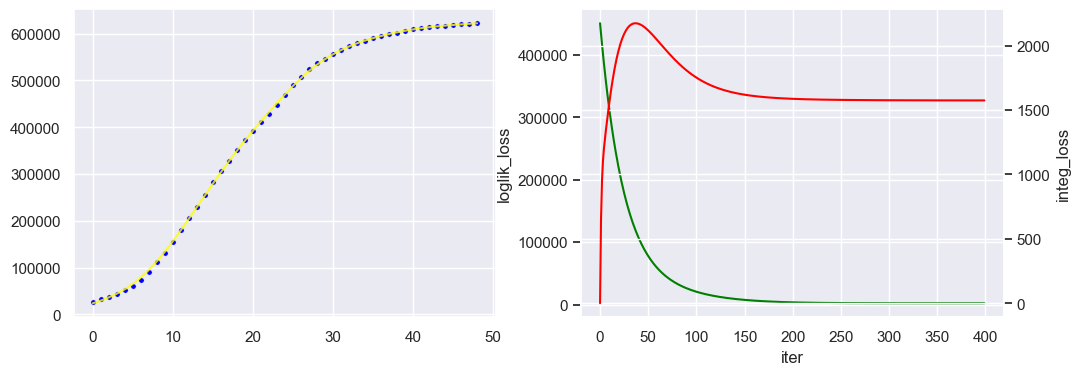

In [121]:
bs_coeff_local_opt(
    ser,
    kappa,
    mu,
    tau,
    bs_interp_prop,
    interg_interp_prop,
    labd,
    lr,
    decay,
    iters,
    show_process,
)

## Optimize Theta Globally

In [122]:
def model_theta_global_opt(
    ser,
    kappa_init,
    mu_init,
    tau_init,
    bs_interp_prop,
    interg_interp_prop,
    labd,
    bs_lr_schedule,
    theta_lr_schedule,
    early_stop_ratio,
    show_process="outer",
):
    losses = [np.inf]
    theta = np.array([kappa_init, mu_init, tau_init])
    theta_selected = theta.copy()
    iters_bs, lr_bs, decay_bs = bs_lr_schedule
    iters_theta, lr_theta, decay_theta = theta_lr_schedule

    if show_process == "outer":
        show_process_bs, show_process_theta = False, True
    elif show_process == "inner":
        show_process_bs, show_process_theta = True, False
    elif show_process == "both":
        show_process_bs, show_process_theta = True, True
    else:
        show_process_bs, show_process_theta = False, False

    for iter_theta_ in range(iters_theta):
        theta_grad, loss_, fitted_ser = bs_coeff_local_opt(
            ser,
            theta[0],
            theta[1],
            theta[2],
            bs_interp_prop,
            interg_interp_prop,
            labd,
            lr_bs,
            decay_bs,
            iters_bs,
            show_process_bs,
        )
        if loss_ == np.inf or loss_ / min(losses) > early_stop_ratio:
            break
        theta[0] -= lr_theta * theta_grad[0]
        theta[1] -= lr_theta * theta_grad[1]
        theta[2] -= lr_theta * theta_grad[2]
        if min(losses) > loss_:
            theta_selected = theta.copy()
            fitted_ser_selected = fitted_ser.copy()
        lr_theta = lr_theta * decay_theta
        losses.append(loss_)
        if show_process_theta:
            print("inter {}: Theta: {} Loss: {}".format(iter_theta_, theta, loss_))
    if show_process_theta:
        plt.figure(figsize=(12, 6))
        ax = sns.lineplot(x=range(len(losses)), y=losses)
        ax = sns.scatterplot(x=range(len(losses)), y=losses)
    return theta_selected, losses, fitted_ser_selected

In [123]:
kappa_init, mu_init, tau_init = 0.59, 1.0, 1.81

inter 0: Theta: [0.58887433 1.00053602 1.81149724] Loss: 64909.904475012736
inter 1: Theta: [0.58779746 1.0012148  1.81300756] Loss: 61339.091049272436
inter 2: Theta: [0.58679823 1.00217834 1.81453508] Loss: 57332.09117639679
inter 3: Theta: [0.58594523 1.00383542 1.81609898] Loss: 52323.179745405585
inter 4: Theta: [0.58526598 1.00696623 1.81778151] Loss: 48305.74717409701
inter 5: Theta: [0.58450889 1.01020529 1.81959672] Loss: 56315.12689637518


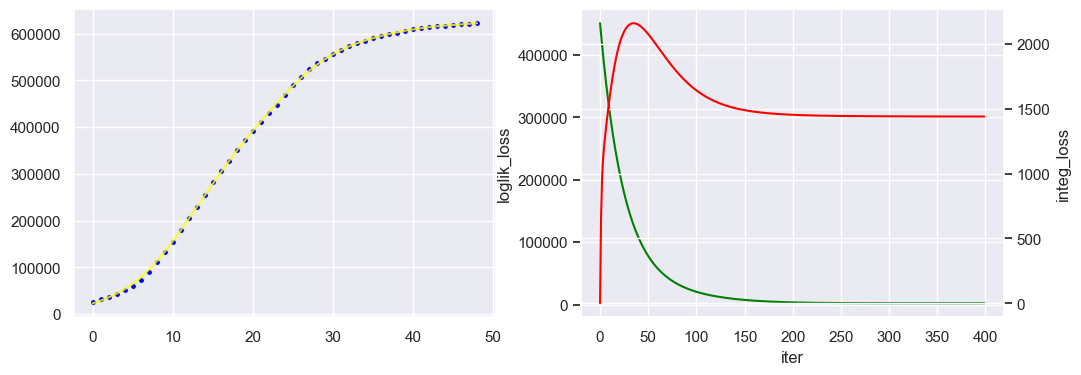

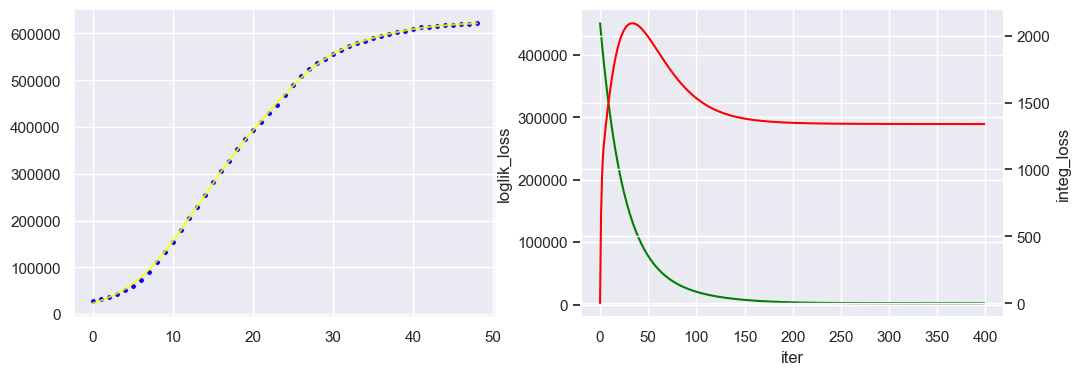

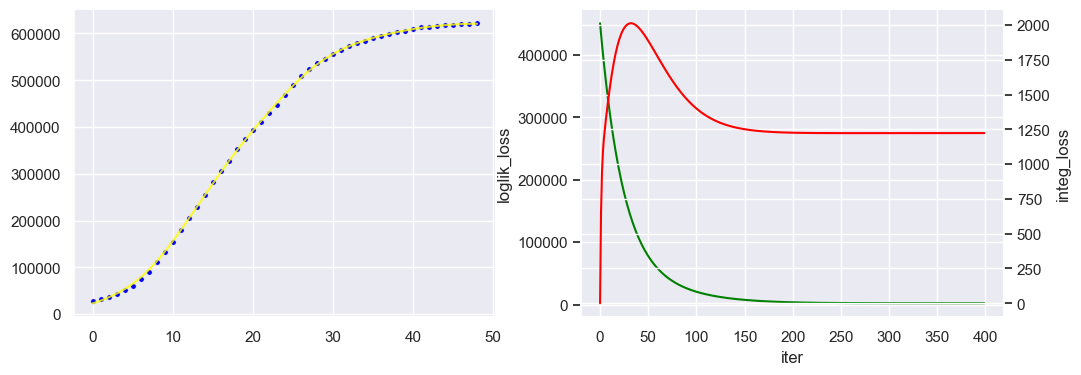

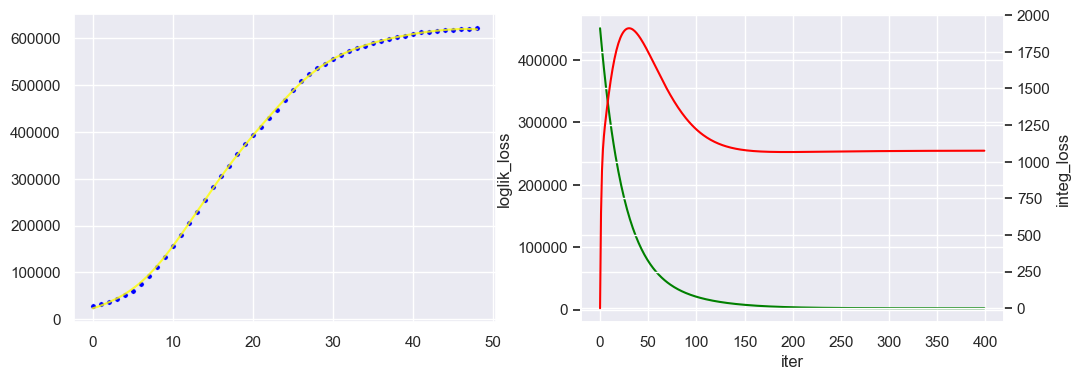

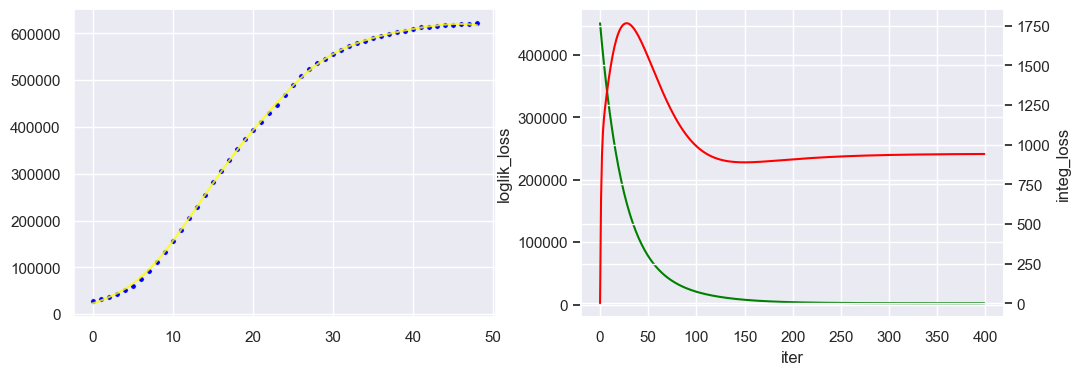

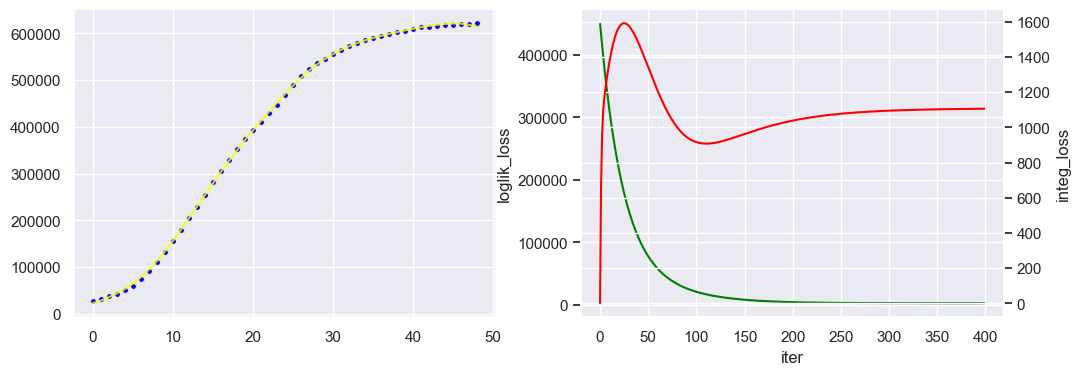

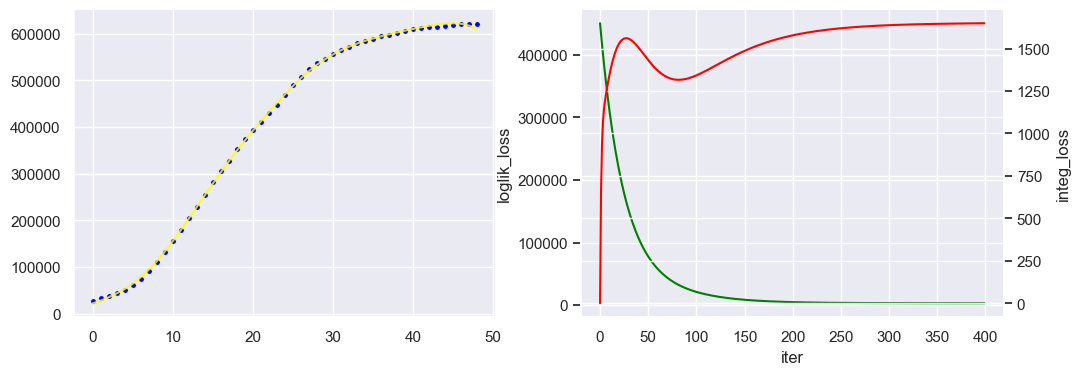

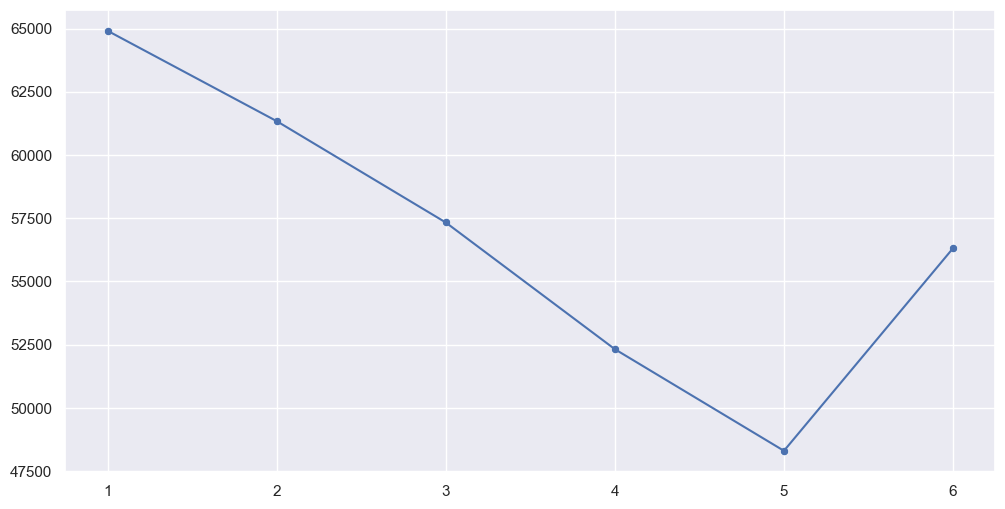

In [128]:
theta_opt, losses, fitted_opt = model_theta_global_opt(
    ser,
    kappa_init=kappa_init,
    mu_init=mu_init,
    tau_init=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=500.0,
    labd=5.0,
    bs_lr_schedule=(int(4e2), 0.02, 0.999),
    theta_lr_schedule=(int(2e2), 0.1, 0.99),
    early_stop_ratio=1.2,
    show_process="both",
)

<AxesSubplot:>

<AxesSubplot:>

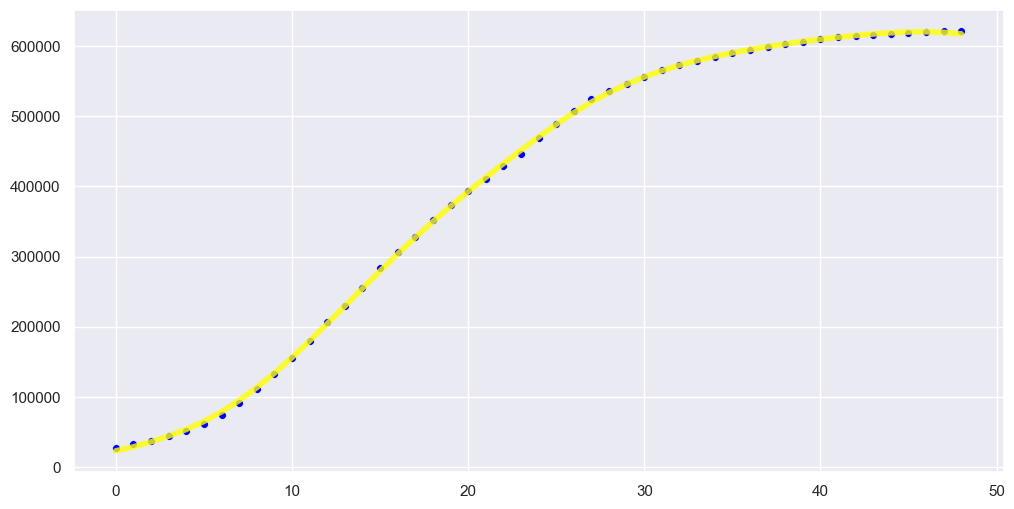

In [147]:
sns.scatterplot(x=range(len(ser)), y=ser, alpha=1.0, color="blue", s=32)
sns.lineplot(x=range(len(ser)), y=fitted_opt, alpha=0.8, color="yellow", linewidth=4)

# Application